## Optimal Order Execution Region (spread long-short regions) and Trading Backtest

entering long at: 174.76
exiting long at: 189.76999999999998, total_value: 115.00999999999999
entering short at: 189.76999999999998
exiting short at: 180.84, total_value: 123.93999999999997
entering long at: 180.84
exiting long at: 197.8, total_value: 140.89999999999998
entering short at: 197.8
exiting short at: 194.99, total_value: 143.70999999999998
entering long at: 194.99
exiting long at: 203.3, total_value: 152.01999999999998
entering short at: 203.3
exiting short at: 200.3364, total_value: 154.9836
entering long at: 200.3364
exiting long at: 207.83, total_value: 162.4772
entering short at: 207.83
exiting short at: 204.285, total_value: 166.02220000000003
entering long at: 204.285
exiting long at: 207.55, total_value: 169.28720000000004
entering short at: 207.55
exiting short at: 204.85999999999999, total_value: 171.97720000000007
entering long at: 204.85999999999999
exiting long at: 209.03, total_value: 176.14720000000008
entering short at: 209.03
exiting short at: 208.56, total_

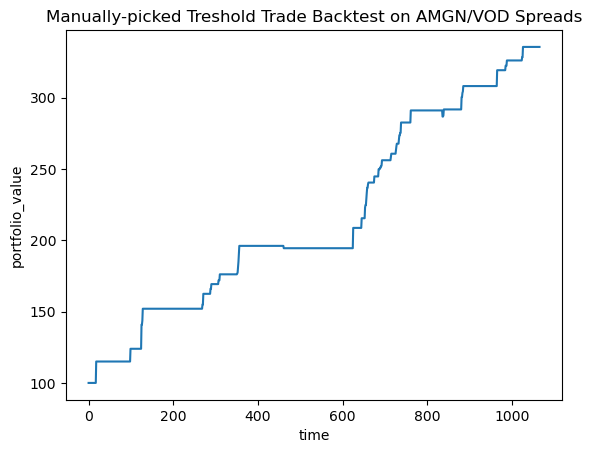

In [57]:
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# We define a backtesting method, that takes
# long-short tresholds and performs a backtest
# this is an oversimplified model that doesn't
# factor in the parameters of the underlying OU
# process and simply trades off arbitrarily
# defined tresholds, this follows an unoptimized
# P/L, which we will later optimize for risk
# appetite or optimality

TEST_SET_END = 1450
DATA_BASE = '../data/nasdaq/'
TICKER_BASE = 'AMGN'
TICKER_AUX = 'VOD'

base_path = os.path.join(DATA_BASE, TICKER_BASE + '.pkl')
aux_path = os.path.join(DATA_BASE, TICKER_AUX + '.pkl')

base = pd.read_pickle(base_path)
aux = pd.read_pickle(aux_path)
spreads = base - aux

def backtest(treshold_down: float, treshold_up: float) -> list[float]:
    train_set_spreads = spreads[0:TEST_SET_END]
    
    test_set_spreads = spreads[TEST_SET_END:]
    test_set_len = len(test_set_spreads)
    
    # perform OLS fitting to X_{t} = \beta Y_{t} + \alpha
    x = list(range(len(train_set_spreads)))
    y = train_set_spreads[0]

    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    res = model.fit()

    slope = res.params['x1']
    intercept = res.params['const']

    # perform backtest trading off tresholds
    total_value = 100
    portfolio_values = []

    entered_long = False
    long_entrance_price = 0

    entered_short = False
    short_entrance_price = 0

    for i in range(test_set_len):
        value = test_set_spreads.iloc[i, 0]

        real_time = TEST_SET_END + i
        pred_value = intercept + (slope * real_time)

        if value - treshold_up > pred_value:
            # End long position on spread
            if entered_long:
                entered_long = False
                total_value += (value - long_entrance_price)
                long_entrance_price = 0
                
                print(f'exiting long at: {value}, total_value: {total_value}')

            # short spread
            if not entered_short:
                entered_short = True
                short_entrance_price = value

                print(f'entering short at: {value}')

        elif value + treshold_down < pred_value and not entered_long:
            # End short position on spread
            if entered_short:
                entered_short = False
                total_value += -(value - short_entrance_price)
                short_entrance_price = 0

                print(f'exiting short at: {value}, total_value: {total_value}')

            # long-spread
            if not entered_long:
                entered_long = True
                long_entrance_price = value

                print(f'entering long at: {value}')

        portfolio_values.append(total_value)

    print(f'total startegy value: {total_value}')
    return portfolio_values


TRADE_DOWN = -15
TRADE_UP = 10

portfolio = backtest(TRADE_DOWN, TRADE_UP)
portfolio_df = pd.DataFrame({
    'time': range(len(portfolio)),
    'portfolio_value': portfolio
})

plt.title('Manually-picked Treshold Trade Backtest on AMGN/VOD Spreads')
sns.lineplot(data=portfolio_df, x='time', y='portfolio_value')
plt.show()

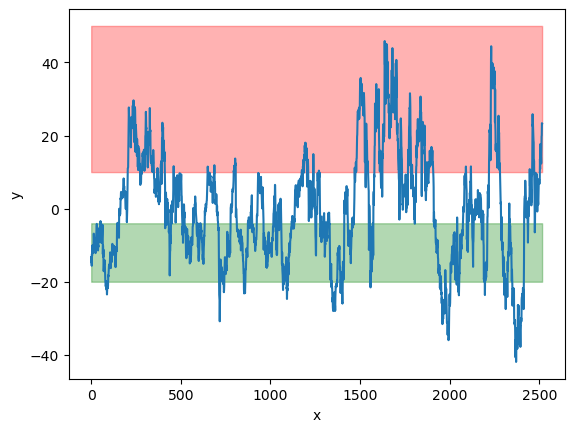

In [54]:
# plot trading tresholds

x = range(len(spreads))
y = spreads[0]

x = sm.add_constant(x)
model = sm.OLS(y, x)
res = model.fit()

residuals = res.resid
residuals_df = pd.DataFrame({
    'x': range(len(spreads)),
    'y': residuals
})

ax = sns.lineplot(data=residuals_df, x='x', y='y')

ax.fill_between(
    residuals_df['x'],
    -20,
    -4,
    alpha=0.3,
    color='green'
)

ax.fill_between(
    residuals_df['x'],
    TRADE_UP,
    50,
    alpha=0.3,
    color='red'
)

plt.show()